*Reference*: https://www.kaggle.com/irinahulea/covid-19-vaccination-progress-eda-predictions/
## Project Objectives
- What vaccines are used and in which countries?
- What country is vaccinated more people?
- What country is vaccinated a larger percent from its population?
- Make predictions about when countries will reach 25%, 50% and 70% of the population vaccination thresholds
- Attempt to work with live data from Google API

## Importing packages

In [330]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Importing and merging data

In [331]:
#reading in country vaccination data
vaccinations = pd.read_csv('country_vaccinations.csv')
vaccinations.head()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
0,Afghanistan,AFG,2021-02-22,0.00,0.00,NaN,NaN,NaN,0.00,0.00,NaN,NaN,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm...",World Health Organization,https://covid19.who.int/
1,Afghanistan,AFG,2021-02-23,NaN,NaN,NaN,NaN,1367.00,NaN,NaN,NaN,35.00,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm...",World Health Organization,https://covid19.who.int/
2,Afghanistan,AFG,2021-02-24,NaN,NaN,NaN,NaN,1367.00,NaN,NaN,NaN,35.00,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm...",World Health Organization,https://covid19.who.int/
3,Afghanistan,AFG,2021-02-25,NaN,NaN,NaN,NaN,1367.00,NaN,NaN,NaN,35.00,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm...",World Health Organization,https://covid19.who.int/
4,Afghanistan,AFG,2021-02-26,NaN,NaN,NaN,NaN,1367.00,NaN,NaN,NaN,35.00,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm...",World Health Organization,https://covid19.who.int/


In [332]:
vaccinations.shape

(29412, 15)

In [333]:
#keeping useful columns and eliminating the rest
vaccinations = vaccinations[['date', 
                             'country', 
                             'iso_code', 
                             'daily_vaccinations', 
                             'people_vaccinated_per_hundred',
                             'vaccines',
                            ]]
vaccinations.head()

,date,country,iso_code,daily_vaccinations,people_vaccinated_per_hundred,vaccines
0,2021-02-22,Afghanistan,AFG,NaN,0.00,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm..."
1,2021-02-23,Afghanistan,AFG,1367.00,NaN,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm..."
2,2021-02-24,Afghanistan,AFG,1367.00,NaN,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm..."
3,2021-02-25,Afghanistan,AFG,1367.00,NaN,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm..."
4,2021-02-26,Afghanistan,AFG,1367.00,NaN,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm..."


In [334]:
#checking for categorical NaN's
vaccinations.select_dtypes(include=['object']).isnull().sum()

date        0
country     0
iso_code    0
vaccines    0
dtype: int64

In [335]:
#fixing iso codes of UK countries
vaccinations.loc[vaccinations.country.isin(['England', 'Scotland', 'Wales', 'Northern Ireland']), 'iso_code'] = 'GBR'

In [336]:
#reading in continent data, with the intent of adding regional/sub-regional data
continents = pd.read_csv('continents2.csv')
continents.head()

,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.00,34.00,NaN
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.00,154.00,NaN
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NaN,150.00,39.00,NaN
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,NaN,2.00,15.00,NaN
4,American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,NaN,9.00,61.00,NaN


In [337]:
#merging regional/sub-regional data with country vaccinations data
#iso_code column of vaccinations corresponds to alpha-3 columsn of continents
data = vaccinations.merge(continents[['alpha-3', 'region', 'sub-region']],
                          how='left',
                          left_on = 'iso_code',
                          right_on = 'alpha-3',
                         ).drop(columns=['alpha-3'])
data.head()

,date,country,iso_code,daily_vaccinations,people_vaccinated_per_hundred,vaccines,region,sub-region
0,2021-02-22,Afghanistan,AFG,NaN,0.00,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm...",Asia,Southern Asia
1,2021-02-23,Afghanistan,AFG,1367.00,NaN,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm...",Asia,Southern Asia
2,2021-02-24,Afghanistan,AFG,1367.00,NaN,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm...",Asia,Southern Asia
3,2021-02-25,Afghanistan,AFG,1367.00,NaN,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm...",Asia,Southern Asia
4,2021-02-26,Afghanistan,AFG,1367.00,NaN,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm...",Asia,Southern Asia


In [338]:
#renaming columns
#data.columns = ['date', 'country', 'iso_code', 'daily_vaccinations', 'people_vaccinated_per_hundred', 'vaccines', 
#                'continent', 'region']
data.rename(columns = {"region":"continent", "sub-region":"region"}, inplace=True)
data.head()

,date,country,iso_code,daily_vaccinations,people_vaccinated_per_hundred,vaccines,continent,region
0,2021-02-22,Afghanistan,AFG,NaN,0.00,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm...",Asia,Southern Asia
1,2021-02-23,Afghanistan,AFG,1367.00,NaN,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm...",Asia,Southern Asia
2,2021-02-24,Afghanistan,AFG,1367.00,NaN,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm...",Asia,Southern Asia
3,2021-02-25,Afghanistan,AFG,1367.00,NaN,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm...",Asia,Southern Asia
4,2021-02-26,Afghanistan,AFG,1367.00,NaN,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm...",Asia,Southern Asia


In [339]:
#split the Americas into North America and South America, and rename Oceania into Australia and Oceania
data.continent.value_counts()

Europe      9354
Asia        6953
Americas    6260
Africa      5308
Oceania     1308
Name: continent, dtype: int64

In [340]:
data.loc[data.region == 'Northern America', 'continent'] = 'North America'
data.loc[data.region == 'Latin America and the Caribbean', 'continent'] = 'South America'

In [341]:
data.loc[data.continent == 'Oceania', 'continent'] = 'Australia and Oceania'

In [342]:
data.continent.value_counts()

Europe                   9354
Asia                     6953
South America            5520
Africa                   5308
Australia and Oceania    1308
North America             740
Name: continent, dtype: int64

In [343]:
#saving progress
data.to_pickle("vaccinations_merged.pkl")

## Dealing with missing values

In [344]:
data = pd.read_pickle("vaccinations_merged.pkl")

In [345]:
data.isnull().sum()

date                                 0
country                              0
iso_code                             0
daily_vaccinations                 241
people_vaccinated_per_hundred    13851
vaccines                             0
continent                          229
region                             229
dtype: int64

In [346]:
data.loc[data.continent.isnull(), 'iso_code'].value_counts()

OWID_CYN    134
OWID_KOS     95
Name: iso_code, dtype: int64

In [347]:
#we're missing continent/region for Northern Cyprus and Kosovo.
data.loc[data.country == 'Northern Cyprus', 'continent'] = 'Europe'
data.loc[data.country == 'Northern Cyprus', 'region'] = 'Southern Europe'

data.loc[data.country == 'Kosovo', 'continent'] = 'Asia'
data.loc[data.country == 'Kosovo', 'region'] = 'Western Asia'

In [348]:
#missing values for continent/region have been eliminated.
data.isnull().sum()

date                                 0
country                              0
iso_code                             0
daily_vaccinations                 241
people_vaccinated_per_hundred    13851
vaccines                             0
continent                            0
region                               0
dtype: int64

In [349]:
#since missing values for daily_vaccinations makes up a very small percentage of the data...
data.loc[data.daily_vaccinations.isnull()].shape[0] / data.shape[0]

0.008193934448524412

In [350]:
#I'm going to choose to delete those rows.
data = data[~data.daily_vaccinations.isnull()]

In [351]:
#people_vaccinated_per_hundred is more problematic, however. 
data.loc[data.people_vaccinated_per_hundred.isnull()].shape[0] / data.shape[0]

0.47410099070995165

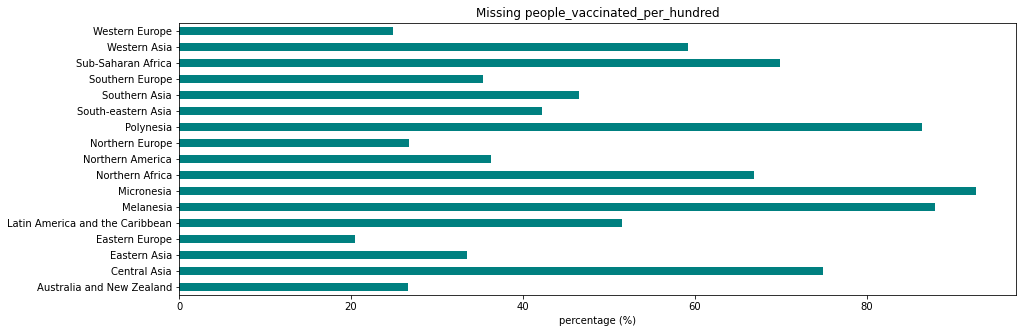

In [352]:
#visualizing percentage of missing people_vaccinated_per_hundred data by region
(data[data.people_vaccinated_per_hundred.isnull()].region.value_counts() / data.region.value_counts()
).mul(100).plot.barh(color="teal", figsize=(15,5))

plt.title('Missing people_vaccinated_per_hundred')
plt.xlabel('percentage (%)')
plt.show()

In [353]:
#for countries that have people_vaccinated_per_hundred data at some point, we'll replace its missing values with the most recent
data.sort_values(by='date', inplace=True)
all_countries = list(data.country.unique())

for country in all_countries:
    data.loc[data.country == country, 'people_vaccinated_per_hundred'] = \
    data.loc[data.country == country, 'people_vaccinated_per_hundred'].fillna(method='bfill').fillna(method='ffill')

In [354]:
#cool, we've eliminated all missing values for people_vaccinated_per_hundred,
#replacing them with the most recent data we could find
data.loc[data.people_vaccinated_per_hundred.isnull()].shape[0] / data.shape[0]

0.0

In [355]:
#saving progress
data.to_pickle("vaccinations_cleaned.pkl")

## Data Analysis

In [356]:
data = pd.read_pickle("vaccinations_cleaned.pkl")